<a href="https://colab.research.google.com/github/Emeron16/UCSD/blob/main/HandGesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# Organize the data

## Create labels

In [ ]:
path = '/Volumes/Datasets/HandGesture/'

In [ ]:
# Create classes (directories) if they don't exist
for dir_name in ['Left Swipe', 'Thumbs Down', 'Stop Gesture', 'Thumbs Up', 'Right Swipe']:
    target_dir_path = os.path.join(path, dir_name)
    if not os.path.exists(target_dir_path):
        os.makedirs(target_dir_path)


keywords_to_dirs ={
    'Left Swipe': 'Left Swipe',
    'Thumbs Down': 'Thumbs Down',
    'Stop Gesture': 'Stop Gesture',
    'Thumbs Up': 'Thumbs Up',
    'Right Swipe': 'Right Swipe'
}


# Iterate through the directories and subdirectories
for root, dirs, files in os.walk(os.path.join(path, 'raw train data')):
    for dir_name in dirs:
        for keyword, target_dir in keywords_to_dirs.items():
            if keyword in dir_name:
                source_dir = os.path.join(root, dir_name)

                # Full path to the target directory where files should be copied
                full_target_dir = os.path.join(path, target_dir)

                # Copy each file in the source directory to the target directory
                for file_name in os.listdir(source_dir):
                    file_path = os.path.join(source_dir, file_name)
                    if os.path.isfile(file_path):  # Ensure it's a file
                        shutil.copy(file_path, full_target_dir)
                        print(f"Copied {file_name} to {full_target_dir}")

print("Files copied successfully.")

## Create Train/Validation/Test folders

In [ ]:
os.chdir('/Volumes/Datasets/HandGesture/')

if os.path.isdir('train/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    folder_name = ['Left Swipe', 'Right Swipe', 'Stop Gesture', 'Thumbs Down', 'Thumbs Up']
    for name in folder_name:
        # Create the target subdirectory in the 'train' folder
        target_train_dir = os.path.join('train', name)
        os.mkdir(target_train_dir)

        # Copy the contents of the source folder to the target subdirectory
        shutil.copytree(name, target_train_dir, dirs_exist_ok=True)

        # Create the corresponding validation and test directories
        os.mkdir(f'valid/{name}')
        os.mkdir(f'test/{name}')

        # Select and move validation samples
        valid_samples = random.sample(os.listdir(target_train_dir), 200)
        for j in valid_samples:
            shutil.move(os.path.join(target_train_dir, j), f'valid/{name}')

        # Select and move test samples
        test_samples = random.sample(os.listdir(target_train_dir), 100)
        for k in test_samples:
            shutil.move(os.path.join(target_train_dir, k), f'test/{name}')

    os.chdir('../..')

# **Preprocess data using Mobilenet**


In [2]:
# Paths to train/valid/test directories
path = '/content/drive/MyDrive/Dataset/HandGesture/'
train_path =  path+'train'
valid_path = path+'valid'
test_path = path+'test'

In [3]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory = train_path, target_size=(224,224), batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory = valid_path, target_size=(224,224), batch_size = 10)
    #Set shuffle equal to false
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory = test_path, target_size=(224,224), batch_size = 10,\
                        shuffle=False)

Found 4020 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


## Verify batches

In [4]:
assert train_batches.n == 4020
assert valid_batches.n == 1000
assert test_batches.n == 500
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 5

## View training batch images

In [4]:
# Get the mapping from class index to class label (name)
def PlotImages(batches):
  images, label = next(batches)
  class_labels = {v: k for k, v in batches.class_indices.items()}

  fig, ax = plt.subplots(ncols=6, figsize=(20,20))

  for i in range(0,6):
      ax[i].imshow(images[i])
      ax[i].title.set_text(f'{class_labels[label[i].argmax()]}')


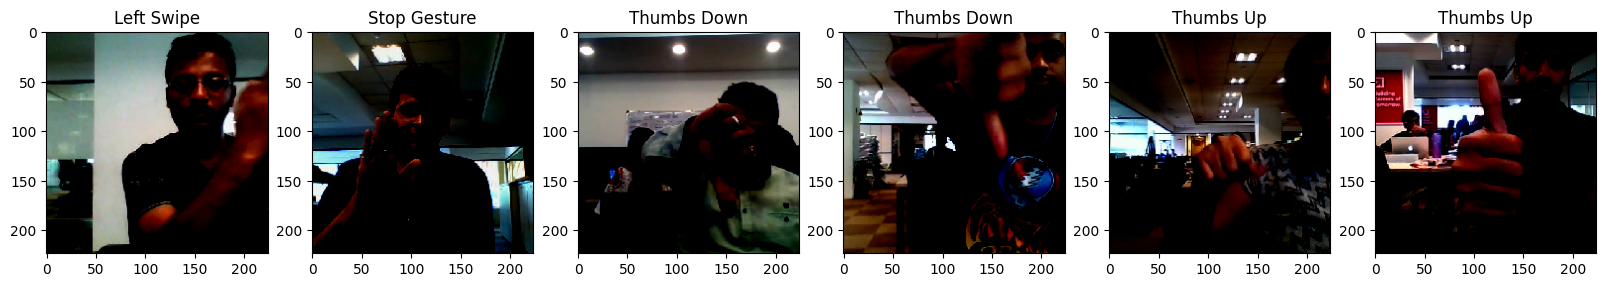

In [7]:
PlotImages(train_batches)

# Modify MobileNet Model

In [11]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

## Specify layers to be used in Model

In [13]:
x = mobile.layers[-1].output
output = Dense(units=5, activation= 'softmax')(x)

## Create model from Mobilenet using modification

In [14]:
model = Model(inputs= mobile.input, outputs=output)

## Freeze Layers

In [15]:
#Freezes top 23 layers
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,258,869 (16.25 MB)

 Trainable params: 2,887,029 (11.01 MB)

 Non-trainable params: 1,371,840 (5.23 MB)

# Build Sequential Model (Optional)

In [4]:
model = Sequential()

In [5]:
model.add(Conv2D(16, 3, padding='same',  activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding='same' , activation = 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding='same',  activation = 'relu'))
model.add(MaxPool2D())

#Condense the layer down to a single dimension
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,870,181 (49.10 MB)

 Trainable params: 12,870,181 (49.10 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
es = EarlyStopping(monitor= 'val_accuracy', patience = 5)

In [8]:
hist = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, callbacks = [es])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


402/402 ━━━━━━━━━━━━━━━━━━━━ 3521s 9s/step - accuracy: 0.7996 - loss: 0.6084 - val_accuracy: 0.9950 - val_loss: 0.0257
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 97s 133ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 1.0000 - loss: 6.8718e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 1.0000 - loss: 3.8342e-04 - val_accuracy: 0.9990 - val_loss: 0.0014
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 1.0000 - loss: 2.4357e-04 - val_accuracy: 0.9990 - val_loss: 0.0012
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 1.0000 - loss: 1.7034e-04 - val_accuracy: 0.9990 - val_loss: 0.0015


# **Save the Model**

In [11]:
code_path = '/content/drive/MyDrive/Dataset/HandGesture/Model'

In [10]:
model.save(os.path.join(code_path,'SequentialModel.keras'))

# **Load the Model**

In [12]:
model = load_model(os.path.join(code_path,'SequentialModel.keras'))

In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,032,929 (38.27 MB)

 Trainable params: 2,887,029 (11.01 MB)

 Non-trainable params: 1,371,840 (5.23 MB)

 Optimizer params: 5,774,060 (22.03 MB)

# **Test Performance**

## View test batches images

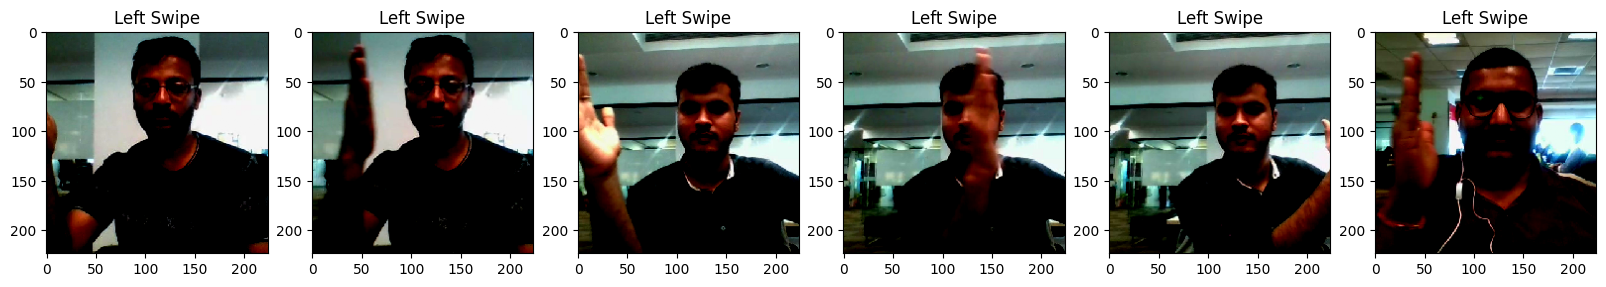

In [6]:
PlotImages(test_batches)

## Predict


In [16]:
#Note: test labels werent shuffled in preprocessing, so they should be organized. Confirm
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [13]:
predictions = model.predict(x=test_batches, verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [19]:
#Results of prediction
np.round(predictions)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## Confusion Matrix

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    '''This function prints and plots the confursion matrix.
    Normalization can be applied by setting "normalize=True".'''

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment ='center', color='white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
test_batches.class_indices

{'Left Swipe': 0,
 'Right Swipe': 1,
 'Stop Gesture': 2,
 'Thumbs Down': 3,
 'Thumbs Up': 4}

In [21]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[100   0   0   0   0]
 [  0 100   0   0   0]
 [  0   0 100   0   0]
 [  0   0   0 100   0]
 [  0   0   0   0 100]]


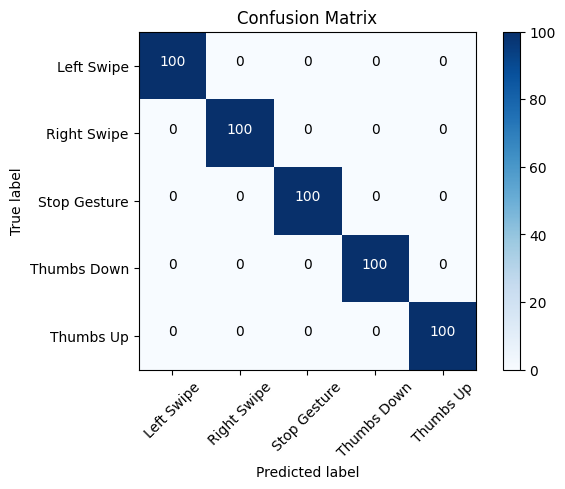

In [22]:
cm_plot_labels = ['Left Swipe', 'Right Swipe', 'Stop Gesture', 'Thumbs Down', 'Thumbs Up']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Plot validation history

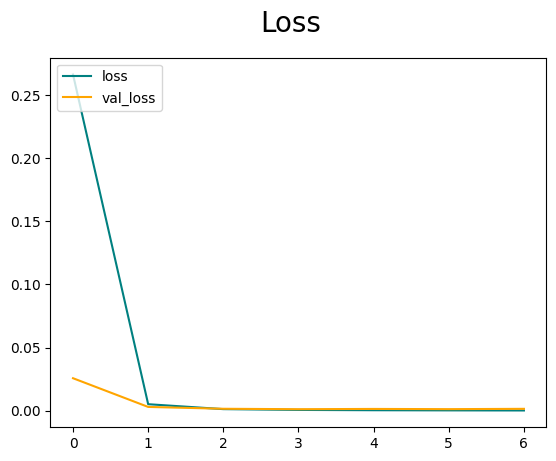

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'],  color = 'teal', label='loss')
plt.plot(hist.history['val_loss'],  color = 'orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Plot accuracy history


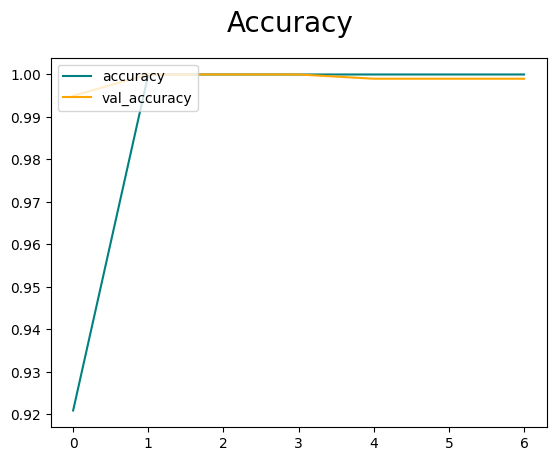

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],  color = 'teal', label='accuracy')
plt.plot(hist.history['val_accuracy'],  color = 'orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Metrics


In [39]:
def Metrics(test_labels, predictions):
  #Accuracy Score
  accuracy = accuracy_score(test_labels, predictions.argmax(axis=1))
  #F1 Score
  f1 = f1_score(test_labels, predictions.argmax(axis=1), average='macro')
  #Top k accuracy score
  test_labels_one_hot = to_categorical(test_labels, num_classes=5)

  top_3_accuracy = top_k_categorical_accuracy(test_labels_one_hot, predictions, k=3)
  # Evaluate the accuracy as a percentage
  top_3_accuracy_result = np.mean(top_3_accuracy)

  print(f"Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nTop-3 Accuracy: {top_3_accuracy_result:.2f}")

In [40]:
Metrics(test_labels, predictions)

Accuracy: 1.00
F1 Score: 1.00
Top-3 Accuracy: 1.00
